# Clique Analysis Directionnal
Conducting a clique analysis of a network graph involves identifying and analyzing the cliques within the graph and the impact on a respective singular token holding metric


In [1]:
import pandas as pd
import numpy as np
from os.path import join
import os


from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_tokens = pd.read_csv("../data/final_token_selection.csv")


In [13]:
import sys
sys.path.append('..') 

from src.analysis.clique_analysis import * 
from src.visualisations.clique_analysis_visualisations import * 

## Create dataframes for each metrics

In [14]:
TOKEN_BALANCE_TABLE_INPUT_PATH = join(path, "../data/snapshot_token_balance_tables_enriched")


ddf = pd.read_csv(join(TOKEN_BALANCE_TABLE_INPUT_PATH, f'token_holder_snapshot_balance_labelled_14779829.csv'), index_col=0)



In [4]:
f_dict = {'CRV': [11659570, 11659570, 11861210], '1INCH': [11659570, 11659570], 'LDO': [11659570, 11861210, 11861210, 12043054, 12043054], 'INST': [12244515, 12244515, 12244515, 12244515, 12438842, 12438842, 12438842, 12438842], 'CVX': [12638919, 12831436]}

In [5]:
fc_dict = {}

# which cliques cause this 
# direction 
# what is the sample size 
# What is the sample population size 


for key, item in f_dict.items(): 
    
    fc_dict[key] = list(set(item))
    
fc_dict

{'CRV': [11861210, 11659570],
 '1INCH': [11659570],
 'LDO': [11861210, 11659570, 12043054],
 'INST': [12438842, 12244515],
 'CVX': [12831436, 12638919]}

In [20]:
import pickle

# Specify the path to the file containing the saved cliques data
clique_data_path = '../data/cliques_data_class.pkl'
clique_data = CliquesData(clique_data_path)


# Use the metric_names attribute from CliquesData
metric_names = clique_data.metric_names

# Initialize an empty dictionary to store DataFrames for each metric
metric_dataframes = {
        'upper_bound': {'sample': {},'control': {},'pvalues': {}, 'sample_directional':{}, 'control_directional':{}, 'pvalues_directional':{}}, # change to adjust nomencalture to we upper to weak 
        'lower_bound': {'sample': {},'control': {},'pvalues': {}, 'sample_directional':{}, 'control_directional':{}, 'pvalues_directional':{}} # change to adjust nomencalture to we lower to strong 
    }
# Create DataFrames for each metric
for method in ['upper_bound', 'lower_bound']:
    for group in ['sample', 'control', 'pvalues', 'sample_directional', 'control_directional', 'pvalues_directional']:
        for metric_name in metric_names:
            metric_dataframes[method][group][metric_name] = clique_data.get_metric_data(method, group, metric_name)
        

### TEST ENVIRONMENT FOR DEVELOPMENT OF HEATMAP CHART FOR DIRECTIONAL SAMPLES 

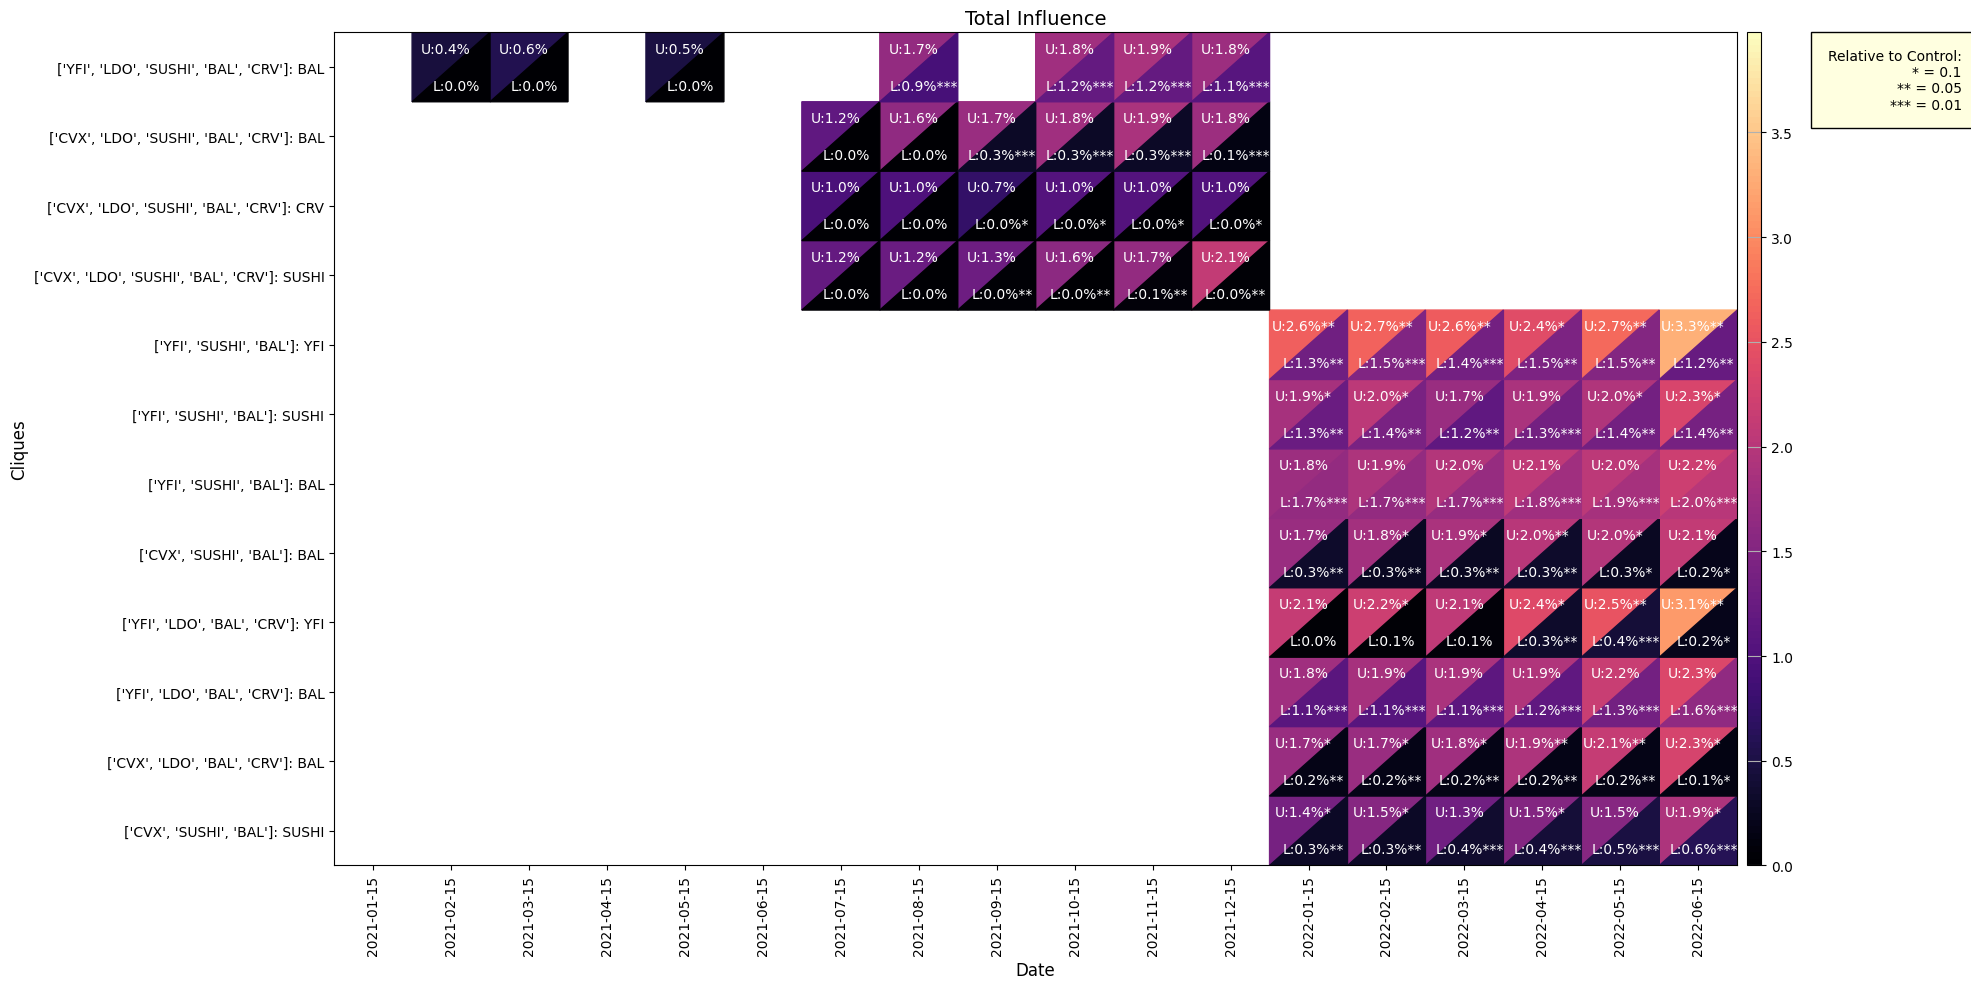

In [30]:
def plot_heatmap_chart_directional(metric_dataframes, metric_name, pct=True, log=False, output_path="./output/cliques/", save=False, show=True):
    FONT_SIZE_LABEL = 12
    FONT_SIZE_TITLE = 14
    FONT_SIZE_TEXT = 10
    FONT_SIZE_VALUE = 10
    FIG_SIZE = (20, 10)

    if pct:
        multiplier = 100
        unit = '%'
    else:
        multiplier = 1
        unit = ''

    if log:
        df_u = np.log10(metric_dataframes['upper_bound']['sample_directional'][metric_name]) * multiplier
        df_l = np.log10(metric_dataframes['lower_bound']['sample_directional'][metric_name]) * multiplier
    else:
        df_u = metric_dataframes['upper_bound']['sample_directional'][metric_name] * multiplier
        df_l = metric_dataframes['lower_bound']['sample_directional'][metric_name] * multiplier

    df_pv_u = metric_dataframes['upper_bound']['pvalues_directional'][metric_name]
    df_pv_l = metric_dataframes['lower_bound']['pvalues_directional'][metric_name]

    # Reindex
    df_index = metric_dataframes['upper_bound']['sample_directional'][metric_name]

    # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()

    # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()

    # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_l = df_l.reindex(cliques_order[::-1])
    df_pv_u = df_pv_u.reindex(cliques_order[::-1])
    df_pv_l = df_pv_l.reindex(cliques_order[::-1])

    # Filter to keep only rows where the count of significant p-values > 3 in either upper or lower bound
    significance_mask_u = df_pv_u.apply(lambda x: x.map(lambda y: pval_to_significance(y) != ''))
    significance_mask_l = df_pv_l.apply(lambda x: x.map(lambda y: pval_to_significance(y) != ''))
    significant_counts_u = significance_mask_u.sum(axis=1)
    significant_counts_l = significance_mask_l.sum(axis=1)
    df_u = df_u[(significant_counts_u > 3) | (significant_counts_l > 3)]
    df_l = df_l.loc[df_u.index]
    df_pv_u = df_pv_u.loc[df_u.index]
    df_pv_l = df_pv_l.loc[df_u.index]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create colormap
    scaling_factor = df_u.max().max() * 1.2
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=scaling_factor)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try:
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except:
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1  # last term manual adjustment
                C_y = (y1 + y2 + y3) / 3 + 0.1  # last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u, 1) if not np.isnan(value_u) else ""}{unit}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1  # last term manual adjustment
                C_y = (y1 + y2 + y3) / 3 - 0.1  # last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l, 1) if not np.isnan(value_l) else ""}{unit}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')

    # Significance box
    plt.text(1.16, 0.98, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01',
             transform=ax.transAxes, fontsize=FONT_SIZE_TEXT,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='lightyellow', alpha=1, pad=12))

    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title(f'{metric_name.replace("_", " ").title()}', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns)) + 0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center', size=FONT_SIZE_TEXT)
    ax.set_yticks(np.arange(len(df_u.index)) + 0.5)
    ax.set_yticklabels(df_u.index, size=FONT_SIZE_TEXT)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/{metric_name}_clique.png", bbox_inches='tight')

    if show:
        plt.show()

# Example usage
plot_heatmap_chart_directional(metric_dataframes, metric_name='total_influence', pct=True, log=False, output_path="../output/links/", save=False, show=True)

## Figure Generation

### Fig: Size of Clique 

In [ ]:
plot_link_size_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

### Fig: link growth over time 

In [ ]:
plot_link_growth_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

In [ ]:
 plot_link_growth_rate_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

In [ ]:
plot_link_stability_vs_no_of_tokens(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

In [ ]:
plot_link_stability_vs_size(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

### Fig: link_size vs total_influence 

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define dfs
#     df_size = metric_dataframes[method][group]['size_clique']
#     df_influence = metric_dataframes[method][group]['total_influence']

#     # Calculate correlations for each timestamp
#     correlations = df_size.corrwith(df_influence, axis=0)

#     # Plotting the correlations
#     plt.figure(figsize=(10, 5))
#     plt.plot(correlations.index, correlations, marker='o', linestyle='-')
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Correlation between Clique Size and Total Influence', fontsize=12)
#     plt.title(f'[{method.upper()}]: Correlation of Clique Size and Total Influence Over Time', fontsize=14)
#     plt.grid(True)

#     plt.xticks(rotation=90)  # Rotate x-tick labels by 90 degrees

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'clique_size_influence_correlation_{method}_{group}.png'))

#     if show:
#         plt.show()
#     else:
#         plt.close()

# # Example usage
# plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)


### Fig: total_influence

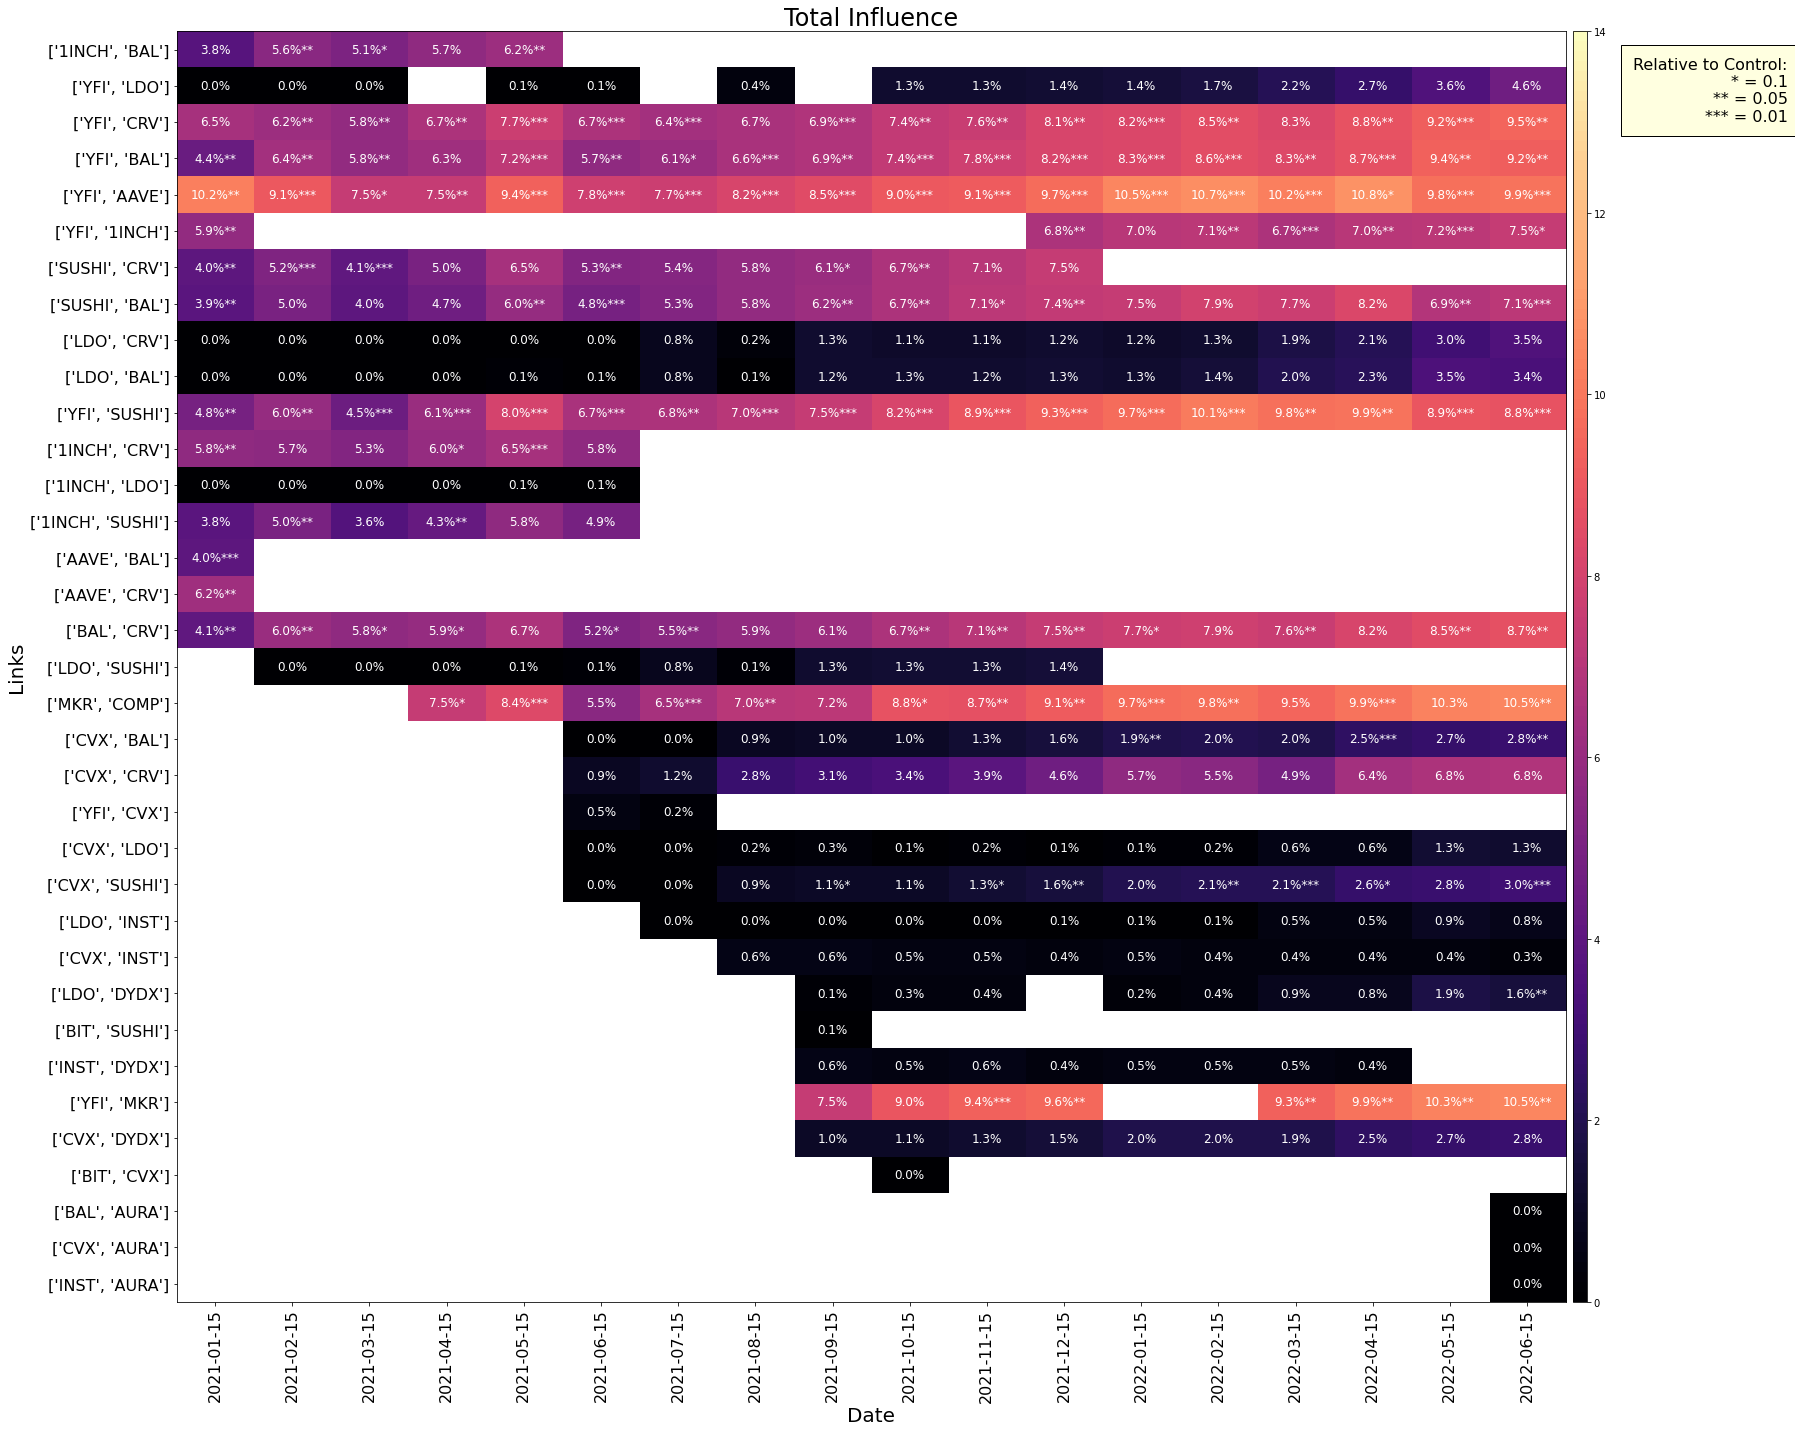

In [5]:
plot_heatmap_chart(metric_dataframes, metric_name='total_influence', pct=True,  log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_total_influence

In [ ]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_total_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: internal_influence 

In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='internal_influence', pct=True,  log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_internal_influence 

In [ ]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_internal_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: external_influence

In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='external_influence', pct=True, log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_external_influence

In [ ]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_external_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: wealth_clique


In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='wealth_link', pct=False, log=True, output_path="../output/links/", save=False, show=True)

### Fig: gini_wealth_clique

In [ ]:

plot_boxplot_with_significance(metric_dataframes, metric='wealth_link', unit='', group='sample', output_path="../output/links/", save=True, show=True)


### Fig: median_no_assets_link


In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='median_no_assets_link', pct=False, log=True, output_path="../output/links/", save=False, show=True)

### Fig: Distribution of Labels

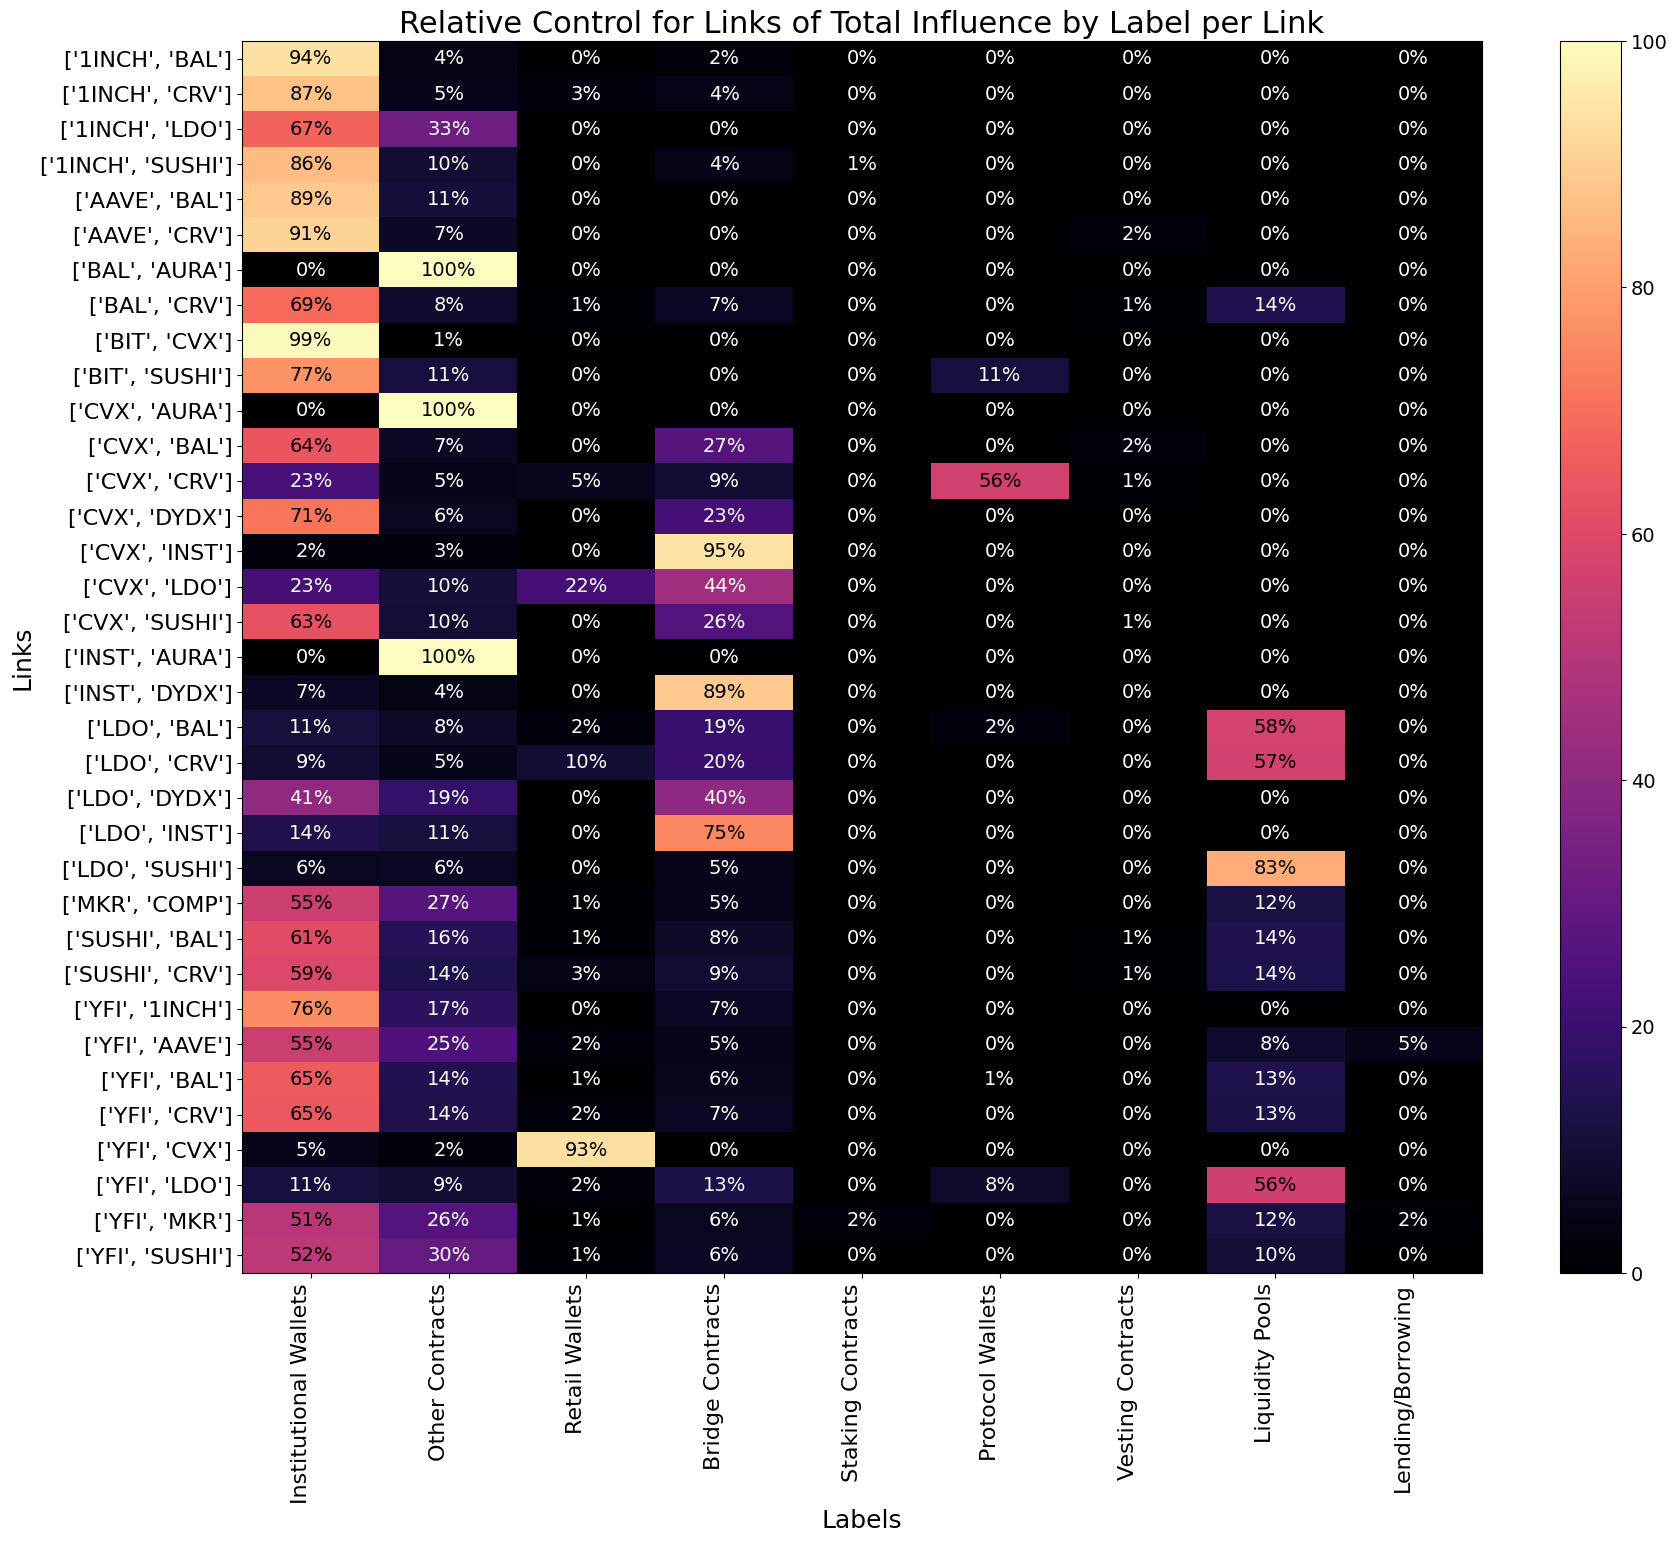

In [14]:
plot_heatmap_labels(metric_dataframes, group='sample', colormap='magma', output_path='../output/links')